<a href="https://colab.research.google.com/github/Jeeeeeeeee/Study/blob/main/TPS08_Scaler_Quantile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

     |████████████████████████████████| 302 kB 6.5 MB/s 
     |████████████████████████████████| 164 kB 64.8 MB/s 
     |████████████████████████████████| 80 kB 8.4 MB/s 
     |████████████████████████████████| 75 kB 5.4 MB/s 
     |████████████████████████████████| 49 kB 8.2 MB/s 
     |████████████████████████████████| 111 kB 70.6 MB/s 
     |████████████████████████████████| 141 kB 51.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=9dc5feff1f6a3a6611ffff17f58f2c6459844b70e8eebdd5fbbd2508982148f8
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics

# import optuna
# from optuna import Trial, visualization

In [3]:
from google.colab import drive
drive.mount('/content/mydrive/')

Mounted at /content/mydrive/


In [4]:
train_path = '/content/mydrive/MyDrive/DATA/train.csv'
test_path = '/content/mydrive/MyDrive/DATA/test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [5]:
target = train['loss']

train.drop(columns = ['id', 'loss'], inplace = True)
test.drop(columns = 'id', inplace=True)

In [6]:
train

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,-0.002350,59,0.766739,-1.350460,42.27270,16.68570,30.35990,1.267300,0.392007,1.09101,1.96874,1.874640,117.286,6.716200,0.985656,0.973428,4004232,0.377896,1.033820,0.574531,0.122371,8.18617,1517.830,3.13219,0.112836,5.01868,116.766,10891,8.193660,5.79715,1.09999,14.86840,-0.275434,0.915721,167.800,-7.534140,4.23632,1.629560,1.144400,-0.303139,...,8.575340e+09,70.9733,0.380057,0.031812,1.09527,0.563482,0.122689,1.160720,1.69391,1.072170,65.15430,0.022504,-5.60680,1.798660,0.528068,6696.3000,-0.562078,1.301020,6.71624,1.143470,2.29983,0.010485,-0.127223,0.231086,4.51614,0.594494,397,0.264022,8.68790,15.070100,0.376622,-42.43990,26.854000,1.45751,0.696161,0.941764,1.828470,0.924090,2.296580,10.489800
1,0.784462,145,-0.463845,-0.530421,27324.90000,3.47545,160.49800,0.828007,3.735860,1.28138,-2.73947,-0.529506,157.670,0.696384,1.441230,0.159056,23567462,-0.089583,-0.711628,-1.045860,0.139920,3.69294,-123.354,7.74097,-0.852302,8.51025,161.175,87801,12.020200,1.78393,1.23100,10.14970,-0.018724,1.011280,127.401,11.821400,5.99681,-0.953850,1.379370,1.079530,...,4.518200e+09,75.5602,1.987990,0.318177,1.14901,0.723574,0.184821,-0.348303,-7.17633,1.462580,43.11210,-0.060801,64.04550,2.358450,5.759690,3958.1400,1.576610,-1.241790,5.91412,0.959826,2.56631,0.000652,-0.335617,-0.271723,5.10319,8.706220,98,0.210513,7.86416,3.371900,0.147973,-184.13200,7.901370,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.364700,1.143830
2,0.317816,19,-0.432571,-0.382644,1383.26000,19.71290,31.10260,-0.515354,34.430800,1.24210,2.90180,-0.960340,118.590,7.696420,1.488760,0.387277,235760,0.055568,0.268560,0.718133,0.027133,11.67340,270.247,3.44051,-0.679071,13.37810,150.362,14173,1.699540,7.04728,1.10513,7.62871,0.685721,0.809485,120.064,194.427000,6.77866,0.634136,0.934386,0.926980,...,8.444970e+08,99.4933,5.098040,0.258909,1.16878,0.049053,0.173547,0.937000,2.05947,1.222450,50.22670,-0.026215,71.68490,2.434170,1.904560,27165.8000,-0.773223,-1.833390,4.98548,1.170870,1.17201,0.016848,-0.235581,-0.724935,3.22565,4.170990,105,-0.155451,8.91829,0.186334,0.335985,7.43721,37.218100,3.25339,0.337934,0.615037,2.216760,0.745268,1.696790,12.305500
3,0.210753,17,-0.616454,0.946362,-119.25300,4.08235,185.25700,1.383310,-47.521400,1.09130,-1.51200,-1.292340,125.461,7.343230,-3.092390,0.713795,1146032,0.326534,0.454842,0.219958,0.037982,5.15195,4893.860,6.89751,-0.830552,4.43184,132.855,77147,32.809000,4.06390,1.11911,3.91776,0.500353,0.206448,120.411,233.537000,7.75131,0.625762,-1.940810,1.333210,...,3.543970e+09,60.8082,2.357590,0.239080,1.16116,0.535797,0.222185,1.163120,2.36343,1.415300,116.18200,0.018674,55.44280,2.228240,4.303600,2643.7600,-1.666320,0.792398,6.45162,1.077330,2.90676,0.023735,-0.091992,-0.098701,4.27820,5.347530,512,0.855981,8.27663,4.066650,0.336490,9.66778,0.626942,1.49425,0.517513,-10.222100,2.627310,0.617270,1.456450,10.028800
4,0.439671,20,0.968126,-0.092546,74.30200,12.30650,72.18600,-0.233964,24.399100,1.10151,1.77348,-0.546781,147.186,17.394300,0.964678,0.964894,19272478,0.121071,0.422461,-0.103100,-0.000910,8.14191,162.713,1.56561,-0.300743,7.56458,160.995,5780,-1.542540,8.09081,1.60582,7.04632,-1.056850,1.727440,126.848,0.910761,6.08868,0.150619,1.134610,1.553550,...,6.379450e+09,103.9900,4.396300,0.248451,1.18082,0.546460,0.140713,0.804404,7.55191,-2.509950,68.24590,0.001230,47.28850,0.461938,1.072440,703.4010,0.691108,5.014080,6.06393,1.120250,1.73348,-0.001272,-0.333872,-0.063781,1.11420,5.233990,109,-0.158318,5.43062,0.991616,0.528518,290.65700,15.604300,1.73557,-0.476668,1.390190,2.195740,0.826987,1.784850,7.071970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

for i, (trn, val) in enumerate(kf.split(train)):
  train.loc[val, 'kfold'] = i
train['kfold'] = train['kfold'].astype(int)

In [ ]:
train['kfold']

0         1
1         1
2         3
3         2
4         0
         ..
249995    4
249996    2
249997    0
249998    1
249999    1
Name: kfold, Length: 250000, dtype: int64

In [ ]:
feature_cols = [col for col in test.columns.tolist()]

In [ ]:
target = train['loss']
train.drop('loss',axis = 1,inplace = True)

In [ ]:
def fit_xgb(trial, xtr, ytr, xval, yval):
    params = {
        "n_estimators": trial.suggest_int("n_estimators",20,100),
        "subsample": trial.suggest_uniform("subsample", 0.5,0.9),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5,0.9),
        "eta": trial.suggest_uniform("eta",0.01,0.2),
        "max_depth": trial.suggest_int("max_depth",3,20),
        "reg_alpha": trial.suggest_int("reg_alpha",1,50),
        'tree_method': 'gpu_hist'
    }
    
    model = xgb.XGBRegressor(**params, random_state = 42, eval_metric="rmse")
    model.fit(xtr, ytr.reshape(-1,))
    
    y_tr_pred = model.predict(xtr)
    y_val_pred = model.predict(xval)
    
    y_tr_pred = np.clip(y_tr_pred, 0.1, None)
    y_val_pred = np.clip(y_val_pred, 0.1, None)
    
    log = {
        "train rmse": np.sqrt(mean_squared_error(ytr, y_tr_pred)),
        "val rmse": np.sqrt(mean_squared_error(yval, y_val_pred))
    }
    
    return model, log

In [ ]:
def objective(trial):
    rmse = 0
    for fold in range(5):
        trn_idx = train['kfold'] != fold
        val_idx = train['kfold'] == fold
        trn = train.loc[trn_idx, :]
        val = train.loc[val_idx, :]

        xtr, ytr = trn[feature_cols].values, target.loc[trn_idx].values
        xval, yval = val[feature_cols].values, target.loc[val_idx].values
        
        model, log = fit_xgb(trial, xtr, ytr, xval, yval)
        rmse += log['val rmse']/5
        
    return rmse

In [ ]:
study = optuna.create_study(direction = "minimize", study_name = 'pérdida')
study.optimize(objective, n_trials = 10)

[I 2021-08-15 07:52:05,434] A new study created in memory with name: pérdida


[07:52:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-15 07:52:15,324] Trial 0 finished with value: 7.876165998840678 and parameters: {'n_estimators': 80, 'subsample': 0.6513377842573997, 'colsample_bytree': 0.7458145603754442, 'eta': 0.03055376893740564, 'max_depth': 7, 'reg_alpha': 43}. Best is trial 0 with value: 7.876165998840678.


[07:52:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-15 07:52:31,905] Trial 1 finished with value: 7.892087236344258 and parameters: {'n_estimators': 100, 'subsample': 0.7250260135711035, 'colsample_bytree': 0.6835292431706799, 'eta': 0.15415038601742076, 'max_depth': 9, 'reg_alpha': 36}. Best is trial 0 with value: 7.876165998840678.


[07:52:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-15 07:52:37,227] Trial 2 finished with value: 7.907982876890113 and parameters: {'n_estimators': 27, 'subsample': 0.5609095700226401, 'colsample_bytree': 0.7325138820246808, 'eta': 0.025917254261740692, 'max_depth': 6, 'reg_alpha': 43}. Best is trial 0 with value: 7.876165998840678.


[07:52:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:53:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:53:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-15 07:53:15,399] Trial 3 finished with value: 7.9381976016066265 and parameters: {'n_estimators': 41, 'subsample': 0.8169927066866935, 'colsample_bytree': 0.5949054765892725, 'eta': 0.032981992904351755, 'max_depth': 15, 'reg_alpha': 30}. Best is trial 0 with value: 7.876165998840678.


[07:53:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:53:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:53:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:53:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:53:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-15 07:53:59,297] Trial 4 finished with value: 7.993044837911058 and parameters: {'n_estimators': 42, 'subsample': 0.5024117963578578, 'colsample_bytree': 0.8964187200521945, 'eta': 0.08111071112618183, 'max_depth': 16, 'reg_alpha': 36}. Best is trial 0 with value: 7.876165998840678.


[07:53:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:54:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:54:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:54:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:54:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-15 07:54:06,011] Trial 5 finished with value: 7.896579640641523 and parameters: {'n_estimators': 31, 'subsample': 0.8531194359240735, 'colsample_bytree': 0.8202765606780562, 'eta': 0.131254004050019, 'max_depth': 8, 'reg_alpha': 42}. Best is trial 0 with value: 7.876165998840678.


[07:54:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:54:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:54:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:55:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:55:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-15 07:56:16,016] Trial 6 finished with value: 8.102841339208224 and parameters: {'n_estimators': 47, 'subsample': 0.534005225637227, 'colsample_bytree': 0.8836486662235141, 'eta': 0.02640075783794913, 'max_depth': 20, 'reg_alpha': 10}. Best is trial 0 with value: 7.876165998840678.


[07:56:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-15 07:56:40,604] Trial 7 finished with value: 7.929614570780124 and parameters: {'n_estimators': 47, 'subsample': 0.6091524912123379, 'colsample_bytree': 0.7421505845066096, 'eta': 0.03315620105668762, 'max_depth': 13, 'reg_alpha': 37}. Best is trial 0 with value: 7.876165998840678.


[07:56:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-15 07:56:48,678] Trial 8 finished with value: 7.870857497182282 and parameters: {'n_estimators': 84, 'subsample': 0.8358831311719631, 'colsample_bytree': 0.7139685983484924, 'eta': 0.06998271303047134, 'max_depth': 6, 'reg_alpha': 16}. Best is trial 8 with value: 7.870857497182282.


[07:56:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-15 07:56:59,372] Trial 9 finished with value: 7.888247334734172 and parameters: {'n_estimators': 79, 'subsample': 0.5370996874479345, 'colsample_bytree': 0.5449866344716046, 'eta': 0.027077238287384217, 'max_depth': 8, 'reg_alpha': 18}. Best is trial 8 with value: 7.870857497182282.


In [ ]:
study.best_params

{'colsample_bytree': 0.7139685983484924,
 'eta': 0.06998271303047134,
 'max_depth': 6,
 'n_estimators': 84,
 'reg_alpha': 16,
 'subsample': 0.8358831311719631}

In [ ]:
clf = xgb.XGBRegressor(**(study.best_params))
clf.fit(train[feature_cols], target, eval_metric="rmse")

[07:57:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7139685983484924,
             eta=0.06998271303047134, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=None, n_estimators=84, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=16,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.8358831311719631, verbosity=1)

In [ ]:
predictions = clf.predict(test[feature_cols])

In [ ]:
sample_submission = pd.read_csv('/content/mydrive/MyDrive/DATA/sample_submission.csv')

In [ ]:
submission = pd.DataFrame({
    'id': np.asarray(sample_submission.id), 
    'loss': predictions.astype(int)
})

submission.to_csv('my_submission.csv', index = False)

# EDA

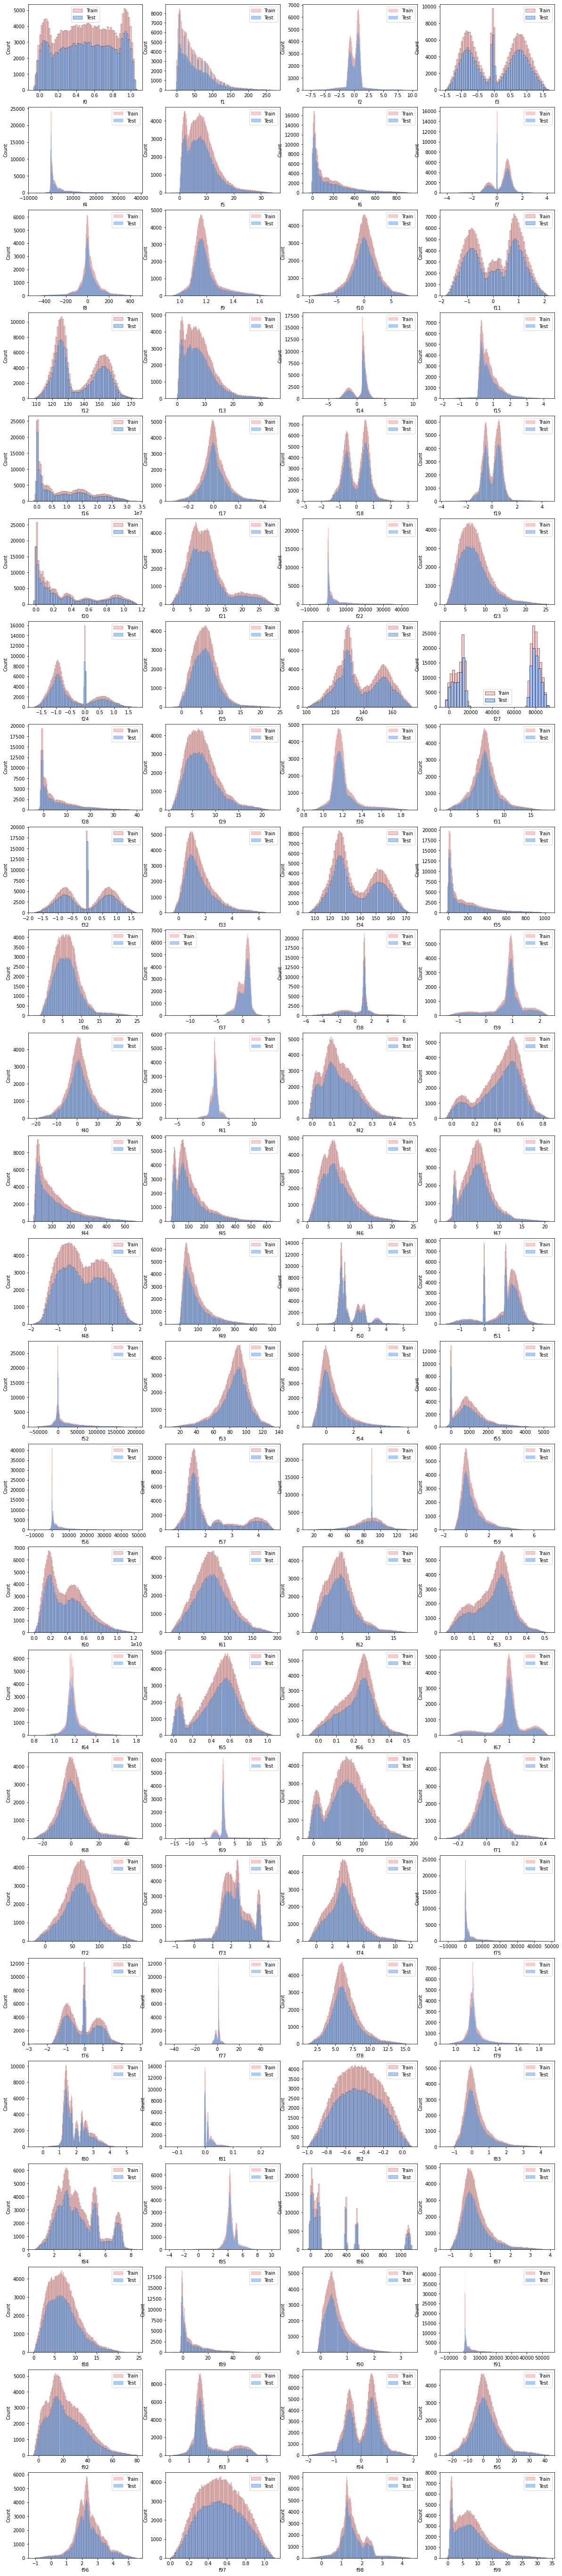

In [8]:
columns = train.columns[:]
plt.subplots(figsize = (20, 200))
length = len(columns)

for i, j in zip(columns, range(length)):
  fig = plt.subplot((length/2), 4, j+1)
  # plt.subplots_adjust(wspace =2, hspace=5)
  sns.histplot(x = train[i], color = '#FFB9B9', edgecolor = 'black')
  sns.histplot(x = test[i], color = '#8BBDFF', edgecolor = 'black')
  fig.legend(labels = ('Train', 'Test'))

  ########### shape:###########
  # Skewed : f1, f4, f6, f15, f20, f21, f22, f28, f30, f33, f35, f38, f39, f42, f43, f44, f49, f54, f55*, f57, f58, f59, f87, f88, f89, f90, f91, f92, f93, f98
  # Bimodal : f2, f12, f14, f18, f19, f24, f26, f27, f34, f45, f47, f65, f77, f81, f85, f94, f99
  # multimodal : f3, f7, f11, f32, f50, f51, f76, f80, f84, f86

In [ ]:
  ########### shape:###########
  # Skewed : f4, f6, f15, f20, f21, f22, f28, f30, f33, f35, f38, f39, f42, f43, f44, f49, f54, f57, f58, f59, f87, f88, f89, f90, f91, f92, f93, f98
  # Bimodal : f2, f12, f14, f18, f19, f24, f26, f34, f45, f47, f65, f77, f81, f85, f94, f99
  # multimodal : f3, f7, f11, f32, f50, f51, f76, f80, f84

In [68]:
# Bimodal
s_cols = ['f4', 'f6', 'f15', 'f20', 'f21', 'f22', 'f28', 'f30', 'f33', 'f35', 'f38', 'f39', 'f42', 'f43', 'f44', 'f49', 'f54', 'f57', 'f58', 'f59', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f98']
b_cols = ['f2', 'f12', 'f14', 'f18', 'f19', 'f24', 'f26', 'f34', 'f45', 'f47', 'f65', 'f77', 'f81', 'f85', 'f94', 'f99']
m_cols = ['f3', 'f7', 'f11', 'f32', 'f50', 'f51', 'f76', 'f80', 'f84']
other_cols = [c for c in train.columns if c not in s_cols+b_cols+m_cols]

skewed_columns = pd.DataFrame(train[s_cols])
bimodal_columns = pd.DataFrame(train[b_cols])
multimodal_columns = pd.DataFrame(train[m_cols])
other_columns = pd.DataFrame(train[other_cols])

In [11]:
# Discrete Features

discrete_features = []

for col in train.columns:
  if np.array_equal(train[col].values, train[col].values.astype(int)):
    discrete_features.append(col)


print(f'Total {len(discrete_features)} : ')
print(discrete_features)

Total 6 : 
['f1', 'f16', 'f27', 'f55', 'f60', 'f86']


In [ ]:
# 1회차
# standard Scaling 

# 2회차
# skewed -> log transformation
# bimodal, multimodal -> quantile transformation
# others -> standard scaling

In [ ]:
# StandardScaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train = pd.DataFrame(scaler.fit_transform(train))
scaled_test = pd.DataFrame(scaler.fit_transform(test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f21c2423f50>,
      dtype=object)

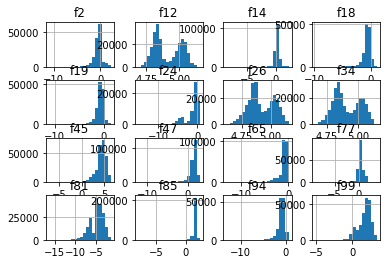

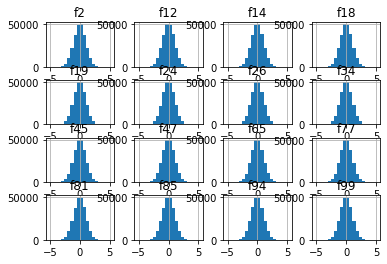

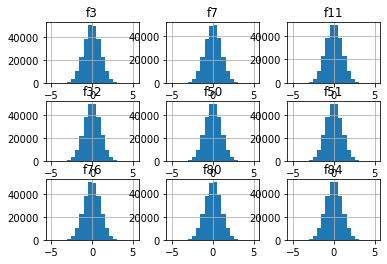

In [79]:
# log Transformation
scaled_train = np.log(bimodal_columns)
scaled_train.hist(bins = 20)

# Quantile 변환
from sklearn.preprocessing import QuantileTransformer
trans = QuantileTransformer(output_distribution='normal')

scaled_train[b_cols] = trans.fit_transform(train[b_cols])
scaled_train[b_cols].hist(bins = 20)

scaled_train[m_cols] = trans.fit_transform(train[m_cols])
scaled_train[m_cols].hist(bins = 20)

In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train_tmp[b_cols] = scaler.fit_transform(train[b_cols])
scaled_train_tmp[b_cols].hist(bins = 20)

NameError: ignored

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f21c12c2050>,
      dtype=object)

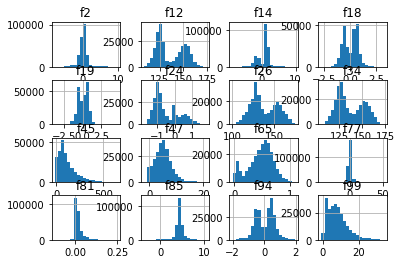

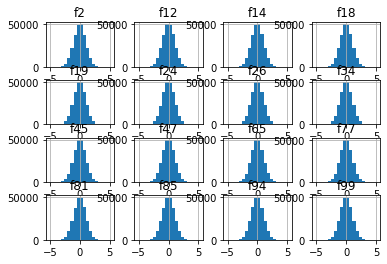

In [80]:
train[b_cols].hist(bins = 20)
scaled_train[b_cols].hist(bins = 20)

In [ ]:
scaled_train

,f2,f12,f14,f18,f19,f24,f26,f27,f34,f45,f47,f65,f77,f81,f85,f94,f99
0,-0.265609,4.764615,-0.014448,0.033261,-0.554201,-2.181820,4.760172,9.295692,5.122773,5.791381,2.000776,-0.573620,0.263149,-4.557771,-0.520045,-0.362174,2.350403
1,NaN,5.060504,0.365497,NaN,NaN,NaN,5.082491,11.382828,4.847340,3.385244,1.261901,-0.323552,NaN,-7.335561,2.164038,NaN,0.134382
2,NaN,4.775672,0.397944,-1.314681,-0.331100,NaN,5.013046,9.559094,4.788025,5.913568,2.059609,-3.014862,NaN,-4.083517,1.428153,-1.084905,2.510046
3,NaN,4.831995,NaN,-0.787805,-1.514319,NaN,4.889258,11.253468,4.790911,3.191928,0.936501,-0.624000,-0.232691,-3.740783,1.676635,-0.658721,2.305461
4,-0.032393,4.991697,-0.035961,-0.861658,NaN,NaN,5.081373,8.662159,4.842990,4.341976,2.104935,-0.604294,1.612250,NaN,1.655174,NaN,1.956139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,-0.410661,4.806902,0.320154,NaN,NaN,-0.423667,4.819935,8.438150,4.836322,2.475159,1.780938,-0.716236,NaN,NaN,1.498307,-0.498397,0.363010
249996,NaN,4.804570,0.122094,NaN,-0.241058,NaN,5.051220,2.944439,5.043154,3.162043,1.089541,-0.506316,0.191694,NaN,NaN,NaN,0.204344
249997,-0.770324,5.061183,0.062242,-0.660202,NaN,NaN,5.046279,11.253183,4.850733,4.817657,1.628289,-0.488820,1.172238,-6.090088,1.695889,NaN,-0.786728
249998,NaN,5.073835,NaN,-0.339704,-0.850728,NaN,4.752762,11.237620,4.781960,4.198212,0.934771,-0.108730,NaN,-7.699005,1.316733,-0.258696,2.003625


In [ ]:
X = scaled_train
X_test = scaled_test

# Rough하게 Pycaret

In [ ]:
!pip install pycaret[full]

     |████████████████████████████████| 264 kB 5.0 MB/s 
     |████████████████████████████████| 1.3 MB 36.7 MB/s 
     |████████████████████████████████| 105 kB 48.3 MB/s 
     |████████████████████████████████| 14.4 MB 23.9 MB/s 
     |████████████████████████████████| 248 kB 54.4 MB/s 
     |████████████████████████████████| 167 kB 54.9 MB/s 
     |████████████████████████████████| 271 kB 53.3 MB/s 
     |████████████████████████████████| 1.7 MB 45.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8 MB 38.2 MB/s 
     |████████████████████████████████| 80 kB 5.4 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 2.0 MB 42.2 MB/s 
     |████████████████████████████████| 101 kB 9.6 MB/s 
     |████████████████████████████████| 131 kB 50.8 MB/s 
     |██████████████████

# XGBOOST

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import optuna
import os

In [ ]:
def train_model_optuna(trial, X_train, X_valid, y_train, y_valid):
  preds = 0

  xgb_params = {
                 "n_estimators": trial.suggest_categorical('n_estimators', [10000]),
                 "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.8),
                 "subsample": trial.suggest_float('subsample', 0.5, 0.95),
                 "colsample_bytree": trial.suggest_float('colsample_bytree', 0.5, 0.95),
                 "max_depth": trial.suggest_int("max_depth", 5, 16),
                 "booster": trial.suggest_categorical('booster', ["gbtree"]),
                 "tree_method": trial.suggest_categorical('tree_method', ["gpu_hist"]),
                 "reg_lambda": trial.suggest_float('reg_lambda', 2, 100),
                 "reg_alpha": trial.suggest_float('reg_alpha', 1, 50),
                 "random_state": trial.suggest_categorical('random_state', [42]),
                 "n_jobs": trial.suggest_categorical('n_jobs', [4]),
  }

  #Model loading and training
  model = XGBRegressor(**xgb_params)
  model.fit(X_train, y_train,
            eval_set = [(X_train, y_train), (X_valid, y_valid)],
            eval_metric = "rmse",
            early_stopping_rounds = 100,
            verbose = True)
  
  print(f"Number of boosting rounds : {model.best_iteration}")
  oof = model.predict(X_valid)
  oof[oof < 0] = 0

  return np.sqrt(mean_squared_error(y_valid, oof))

In [ ]:
y = pd.DataFrame(target)

In [ ]:
# split data
# split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
# for train_idx, valid_idx in split.split(X, target.values):
#   X_train, X_valid = X.loc[train_idx], X.loc[valid_idx]
#   y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

# study = optuna.create_study(direction = 'minimize')
# study.optimize(lambda trial: train_model_optuna(trial, X_train, X_valid,
#                                                 y_train, y_valid),
#                n_trials = 100,
#                )

# # SHOW IT
# print("Number of finished trials :", len(study.trials))
# print("Best trial parameters :", study.best_trial.params)
# print('Best Score :', study.best_value)

In [ ]:
xgb_params = {'n_estimators': 10000,
              'learning_rate': 0.010154255408501112,
              'subsample': 0.8406787739843629,
              'colsample_bytree': 0.7078557348809151,
              'max_depth': 7,
              'booster': 'gbtree',
              'tree_method': 'gpu_hist',
              'reg_lambda': 93.9874814976386,
              'reg_alpha': 33.26324929265035,
              'random_state': 42,
              'n_jobs': 4}

In [ ]:

n_splits = 10
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42)
oof_preds = np.zeros((X.shape[0],))
preds = 0
model_fi = 0
total_mean_rmse = 0

for num, (train_idx, valid_idx) in enumerate(skf.split(X, target.values)):
  X_train, X_valid = X.loc[train_idx], X.loc[valid_idx]
  y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

  model = XGBRegressor(**xgb_params)
  model.fit(X_train, y_train,
            eval_set = [(X_train, y_train), (X_valid, y_valid)],
            eval_metric = "rmse",
            early_stopping_rounds = 100,
            verbose = 100)
  
  preds += model.predict(X_test) / n_splits
  model_fi += model.feature_importances_
  oof_preds[valid_idx] = model.predict(X_valid)
  oof_preds[oof_preds < 0] = 0

  fold_rmse = np.sqrt(mean_squared_error(y_valid, oof_preds[valid_idx]))
  print(f"Fold {num} RMSE : {fold_rmse}")
  total_mean_rmse += fold_rmse / n_splits

print(f"\n Overall RMSE : {total_mean_rmse}")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=10.



[03:25:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.1053	validation_1-rmse:10.1004
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:8.22427	validation_1-rmse:8.23255
[200]	validation_0-rmse:7.90911	validation_1-rmse:7.93978
[300]	validation_0-rmse:7.83345	validation_1-rmse:7.89001
[400]	validation_0-rmse:7.79242	validation_1-rmse:7.8754
[500]	validation_0-rmse:7.75802	validation_1-rmse:7.86724
[600]	validation_0-rmse:7.72453	validation_1-rmse:7.86125
[700]	validation_0-rmse:7.69203	validation_1-rmse:7.85606
[800]	validation_0-rmse:7.66304	validation_1-rmse:7.8518
[900]	validation_0-rmse:7.63359	validation_1-rmse:7.84838
[1000]	validation_0-rmse:7.60678	validation_1-rmse:7.84569
[1100]	validation_0-rmse:7.57833	validation_1-rmse:7.84296
[1200]	validation_0

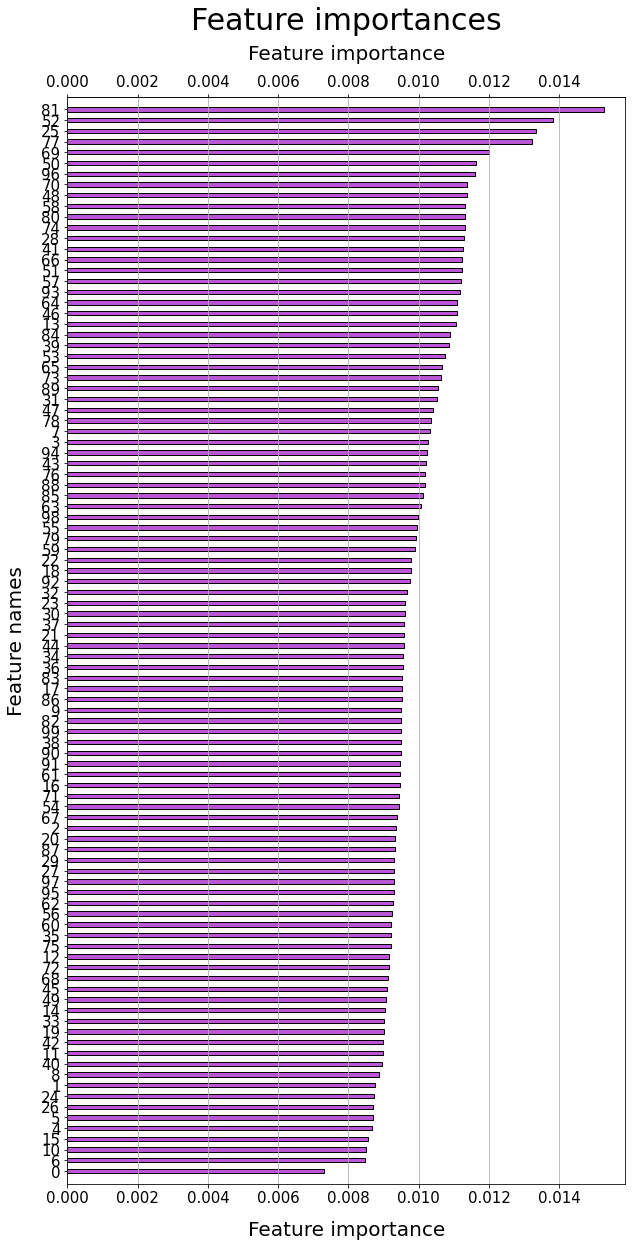

In [ ]:
df = pd.DataFrame(columns=["Feature", "Importance"])
df["Feature"] = X.columns
df["Importance"] = model_fi / model_fi.sum()
df.sort_values("Importance", axis=0, ascending=False, inplace=True)

x = np.arange(0, len(df["Feature"]))
height = 0.4

fig, ax = plt.subplots(figsize=(10, 20))
bars1 = ax.barh(x, df["Importance"], height=height,
                color="mediumorchid", edgecolor="black")
ax.set_title("Feature importances", fontsize=30, pad=15)
ax.set_ylabel("Feature names", fontsize=20, labelpad=15)
ax.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax.set_yticks(x)
ax.set_yticklabels(df["Feature"], fontsize=15)
ax.tick_params(axis="x", labelsize=15)
ax.grid(axis="x")
ax2 = ax.secondary_xaxis('top')
ax2.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax2.tick_params(axis="x", labelsize=15)
plt.margins(0.04, 0.01)
plt.gca().invert_yaxis()

In [ ]:
sample_submission_path = '/content/mydrive/MyDrive/DATA/sample_submission.csv'

submission = pd.read_csv(sample_submission_path)

In [ ]:
submission['loss'] = preds

In [ ]:
submission

,id,loss
0,250000,7.993257
1,250001,4.772370
2,250002,8.459039
3,250003,7.522491
4,250004,7.040478
...,...,...
149995,399995,7.814401
149996,399996,7.353038
149997,399997,5.938583
149998,399998,5.221055


In [ ]:
submission.to_csv('2_submission.csv', index=False)
submission.head()

,id,loss
0,250000,7.993257
1,250001,4.772370
2,250002,8.459039
3,250003,7.522491
4,250004,7.040478
